In [29]:
%load_ext autoreload
%autoreload 2 
import os
import sys 
sys.path.append(os.path.abspath('..'))
import numpy as np
import matplotlib.pyplot as plt
import torch as pt
import arrangements as ar
import emissions as em
import full_model as fm
import spatial as sp
import evaluation as ev
from test_mpRBM import train_sml,make_mrf_data
import pandas as pd
import seaborn as sb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate the true data from a Markov random field

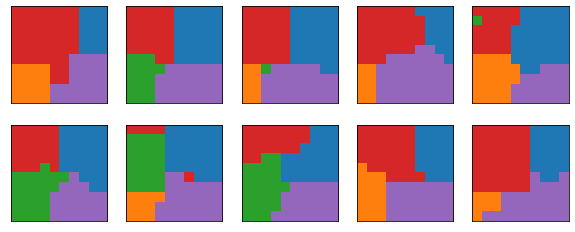

In [9]:
# Make true data: Given that sampling occurrs from a Markov random field, this takes a while
K =5
N=500
sigma2=0.1
Ytrain,Ytest,Utrue,Mtrue =  make_mrf_data(10,K,N,
            theta_mu=20,theta_w=2,sigma2=sigma2,
            do_plot=True)
pt.save([Utrue,Mtrue],'sim_500.pt')


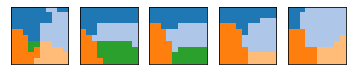

In [37]:
Utrue,Mtrue = pt.load('sim_500.pt')
grid=sp.SpatialGrid(10,10)
grid.plot_maps(Utrue[0:5],grid=(1,5))

### RBM for visible data 
What happens when we use a normal RBM for visible data? 
We can do this, by simply pretending that we are "observing" the p(y|u)
Alternatively, we want to use a RBM for probalistic data- that is the <U> for the M-step p(u|y,theta)

In [38]:
# Define stuff for the evaluation
lossU = 'logpY'
P = Mtrue.arrange.P
    
# Generate partitions for region-completion testing
num_part = 4
p=pt.ones(num_part)/num_part
part = pt.multinomial(p,P,replacement=True)

In [39]:
# Here we fix the emission model to the true emission model 
# and simply work on emission-logliklihoods
Mtrue.emission.sigma2=pt.tensor(0.5)
Ytrain = Mtrue.emission.sample(Utrue.numpy()) # This is the training data
Ytest = Mtrue.emission.sample(Utrue.numpy())  # Testing data

emloglik_train = Mtrue.emission.Estep(Y=Ytrain)
emloglik_test = Mtrue.emission.Estep(Y=Ytest)

In [40]:

n_hidden = 30 # 30 hidden nodes
# Make two versions of the model for fitting
rbm1 = ar.mpRBM_pCD(K,P,n_hidden,eneg_iter=3,eneg_numchains=77)
rbm1.Etype='vis'
rbm1.name = 'vis'

rbm2 = ar.mpRBM_pCD(K,P,n_hidden,eneg_iter=3,eneg_numchains=77)
rbm2.Etype='prob'
rbm2.name = 'prob'
# Check the baseline for independent Arrangement model
indepAr = ar.ArrangeIndependent(K=K,P=P,
        spatial_specific=True,remove_redundancy=False)
indepAr.name = 'indep'

# Now train and record the fit of the models 
n_epoch = 40
batch_size = 20
indepAr,T1 = train_sml(indepAr,
            emloglik_train,emloglik_test,
            part=part,n_epoch=n_epoch,batch_size=N)

# Test normal training of RBM using CDk=1
rbm1, T2 = train_sml(rbm1,
            emloglik_train,emloglik_test,
            part,batch_size=batch_size,n_epoch=n_epoch)
            
rbm2, T3 = train_sml(rbm2,
            emloglik_train,emloglik_test,
            part,batch_size=batch_size,n_epoch=n_epoch)

T = pd.concat([T1,T2,T3],ignore_index=True)

<AxesSubplot:xlabel='iter', ylabel='uerr'>

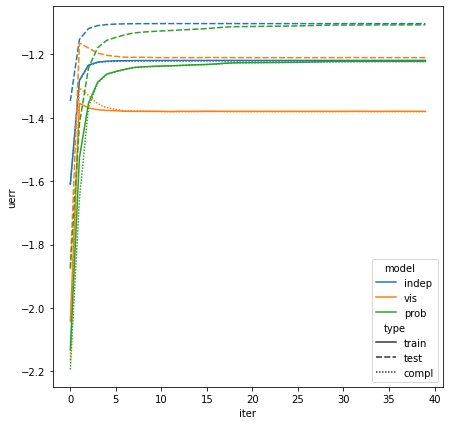

In [41]:


plt.figure(figsize=(7,7))
sb.lineplot(data=T,y='uerr',x='iter',hue='model',style='type')

So we can se that the visual one does not fit the data very well - substantially worse than than the independent one. The probablistic one starts approaching it, but doesn't quite reach it. 
What is the reason for this? 

In [42]:
def plot_marg_prob(emloglik,Utrue,models,title_str):
    num_models = len(models)
    num_rows = int(np.ceil(num_models/2+0.5))
    plt.figure(figsize=(6,8))
    U=ar.expand_mn(Utrue,K)
    pi = U.mean(dim=0)
    piE = pt.softmax(emloglik,dim=1).mean(dim=0)
    plt.subplot(2,num_rows,1)
    plt.scatter(pi,piE)
    plt.title('p(u|y)')
    for m in range(num_models): 
        plt.subplot(2,num_rows,m+2)
        piM = models[m].marginal_prob()
        plt.scatter(pi,piM)
        plt.title(title_str[m])

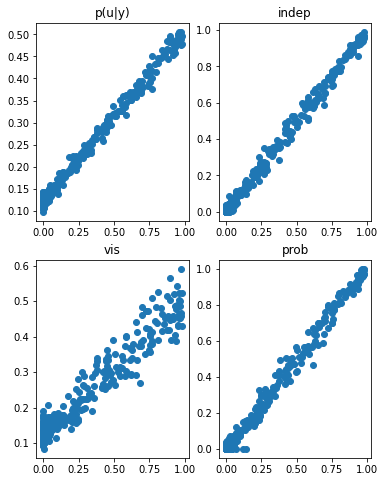

In [43]:
plot_marg_prob(emloglik_test,Utrue,[indepAr,rbm1,rbm2],['indep','vis','prob'])

On the x-axis is the true frequency of each parcel in Utrue. On the y-axis the averaged p(u). The emission model gives much softer probabilities than the true distribution. The independent and probabilistic model learn this, whereas the "visible" RBM learns the average input.  

### Optimizing the probabilistic RBM for hidden nodes
We are going to start of the RBMs with the logpi-values from the independent Arrangement model. Let's have a look at the number of hidden nodes

<AxesSubplot:xlabel='iter', ylabel='uerr'>

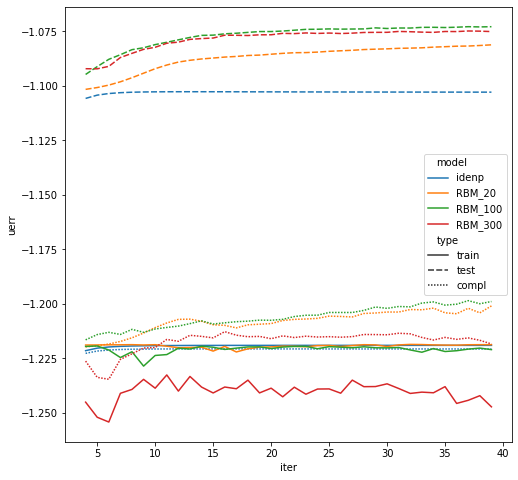

In [48]:
indepAr = ar.ArrangeIndependent(K=K,P=P,spatial_specific=True,remove_redundancy=False)
indepAr.name='idenp'
indepAr,T = train_sml(indepAr,
            emloglik_train,emloglik_test,
            part=part,n_epoch=n_epoch,batch_size=N)

n_hidden = [20,100,300]
for n in n_hidden:
    rbm = ar.mpRBM_pCD(K,P,n,eneg_iter=3,eneg_numchains=200)
    rbm.name=f'RBM_{n}'
    rbm.alpha = 0.001
    rbm.bu=indepAr.logpi.detach().clone()
    rbm.W = pt.randn(n,P*K)*0.1

    rbm, T1 = train_sml(rbm,
            emloglik_train,emloglik_test,
            part,batch_size=batch_size,n_epoch=n_epoch)
    
    T = pd.concat([T,T1],ignore_index=True)

plt.figure(figsize=(8,8))
sb.lineplot(data=T[T.iter>3],y='uerr',x='iter',hue='model',style='type')

From this is seems that hidden units around 100 seems to do quite well, many more hidden units making the basic probablistic atlas (solid line) quite noisy.

### How much is the improvement?
To get a feel to how much we have possibly improved over the independent arrangement model (and how much there is still to go)
Let's plot a few basic maps... 

In [71]:
# First train the Independent and RBM100 model
indepAr = ar.ArrangeIndependent(K=K,P=P,spatial_specific=True,remove_redundancy=False)
indepAr.name='idenp'
indepAr,T = train_sml(indepAr,
            emloglik_train,emloglik_test,
            part=part,n_epoch=n_epoch,batch_size=N)

rbm = ar.mpRBM_pCD(K,P,100,eneg_iter=3,eneg_numchains=200)
rbm.name=f'RBM100'
rbm.alpha = 0.001
rbm.bu=indepAr.logpi.detach().clone()
rbm.W = pt.randn(100,P*K)*0.1

rbm, T1 = train_sml(rbm,
            emloglik_train,emloglik_test,
            part,batch_size=batch_size,n_epoch=n_epoch)


In [77]:
# Get the error from the true pott models
Mpotts = Mtrue.arrange
Mpotts.epos_numchains=100
Mpotts.epos_iter =5
EU,_ = Mpotts.Estep(emloglik_train)
uerr_test1= ev.evaluate_full_arr(emloglik_test,EU)


<AxesSubplot:xlabel='model', ylabel='uerr'>

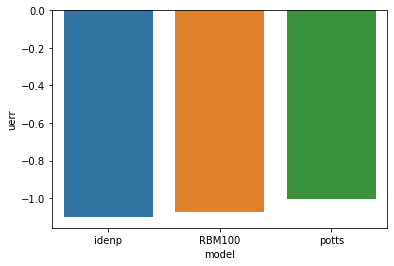

In [90]:
D=pd.concat([T[T.iter==n_epoch-1],T1[T1.iter==n_epoch-1]],ignore_index=True)
dict ={'model':['potts'],'type':['test'],'iter':[1],'uerr':uerr_test1.numpy()}
D1=pd.DataFrame(dict)
D=pd.concat([D,D1])
sb.barplot(data=D[D.type=='test'],x='model',y='uerr')

In [91]:
# Get the expectation 
Uh0=pt.softmax(emloglik_train[0:1],dim=1)
Uh1,_=indepAr.Estep(emloglik_train[0:1])
Uh2,_=rbm.Estep(emloglik_train[0:1])
Uh3,_=Mpotts.Estep(emloglik_train[0:1])

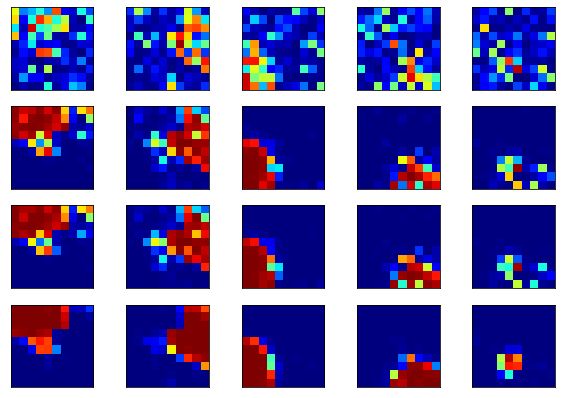

In [92]:
plt.figure(figsize=(10,7))
grid.plot_maps(Uh0[0],cmap='jet',vmax=1,grid=(4,5))
grid.plot_maps(Uh1[0],cmap='jet',vmax=1,grid=(4,5),offset=6)
grid.plot_maps(Uh2[0],cmap='jet',vmax=1,grid=(4,5),offset=11)
grid.plot_maps(Uh3[0],cmap='jet',vmax=1,grid=(4,5),offset=16)

So clearly, a much more subtle change over and above the mean probabilistic atlas....